In [1]:
# * * * * * * * * * * * * * * * *
# Configuration
# * * * * * * * * * * * * * * * *
EXPERIMENT_NUM='6'

DATASET_DIR = '/workspace/datasets'
OUTPUT_DIR = '/workspace/outputs'

TARGET_METRIC='std_temp'
SAMPLE_SIZE=2500

DEVICE = "cpu"

LATENT_DIM=4
BATCH_SIZE=200
EPOCHS=100
BETA=0.2
LEARNING_RATE=1e-3
GAMMA=0.1

INPUT_DIM=(1,120)

In [2]:
import os
from sklearn.preprocessing import StandardScaler
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from torchinfo import summary

from lunar_vae import VAE, train, SampleLatentSpace, VisualizeLatentSpace
from utils import (
    CollectStatisticsFromProfilesV1,
    ConvertProfileListToCsv,
    CreateProfileSubset,
    GenerateDensityPlot,
    GetDataMetrics,
    GetMeanLatentValues,
    LoadProfileList,
    LoadTemperatureDataV1,
    PlotHistograms,
    PlotComparativeHistograms,
    PlotLosses,
    PrintAndLog,
    SaveLossesToCSV,
    SetupOutputDir,
    SplitAndNormalizeData,
)

# * * * * * * * * * * * * * * * *
# Setting Variables
# * * * * * * * * * * * * * * * *
PROFILES_DIR = os.path.join(DATASET_DIR, f'profiles-v1', f'profiles-v1-jsons')
ORIGINAL_PROFILE_LIST_JSON = '/workspace/outputs/profiles-v1/profiles_v1_experiment_2_20250326_0344/profile_list_v1_in_range.json'
LABEL = f'profiles_v1_experiment_{EXPERIMENT_NUM}'
BINNED_PROFILE_LIST = os.path.join(DATASET_DIR, 'profiles-v1', 'profile_list_v1_binned.json')

# * * * * * * * * * * * * * * * *
# Make Directory
# * * * * * * * * * * * * * * * *
model_dir = SetupOutputDir(OUTPUT_DIR, parent_folder=LABEL, sub_folders=["reconstruction_images"])
print(f"Created directory {model_dir}")

Created directory /workspace/outputs/profiles_v1_experiment_6_20250331_0257


In [3]:
# * * * * * * * * * * * * * * * *
# Create Subset by Metric
# * * * * * * * * * * * * * * * *
SUBSET_PROFILE_LIST = os.path.join(model_dir, f'profile_list_v1_{TARGET_METRIC}_{SAMPLE_SIZE}.json')
CreateProfileSubset(BINNED_PROFILE_LIST, SUBSET_PROFILE_LIST, TARGET_METRIC, SAMPLE_SIZE)

In [4]:
# * * * * * * * * * * * * * * * *
# Load Profile List
# * * * * * * * * * * * * * * * *
profile_list = LoadProfileList(SUBSET_PROFILE_LIST)

In [5]:
# * * * * * * * * * * * * * * * *
# Convert to CSV
# * * * * * * * * * * * * * * * *
csv_path = ConvertProfileListToCsv(PROFILES_DIR, profile_list, model_dir)

Processing Profiles: 100%|██████████| 78526/78526 [00:17<00:00, 4541.12it/s]

Saved 78526 profiles to /workspace/outputs/profiles_v1_experiment_6_20250331_0257/20250331-dataset.csv


In [6]:
# * * * * * * * * * * * * * * * *
# Load Temp Data
# * * * * * * * * * * * * * * * *
temp_data = LoadTemperatureDataV1(csv_path, DEVICE)

Loading Profiles: 78526it [00:03, 25524.94it/s]


Saved figure to /workspace/outputs/profiles_v1_experiment_6_20250331_0257/density_plot.png


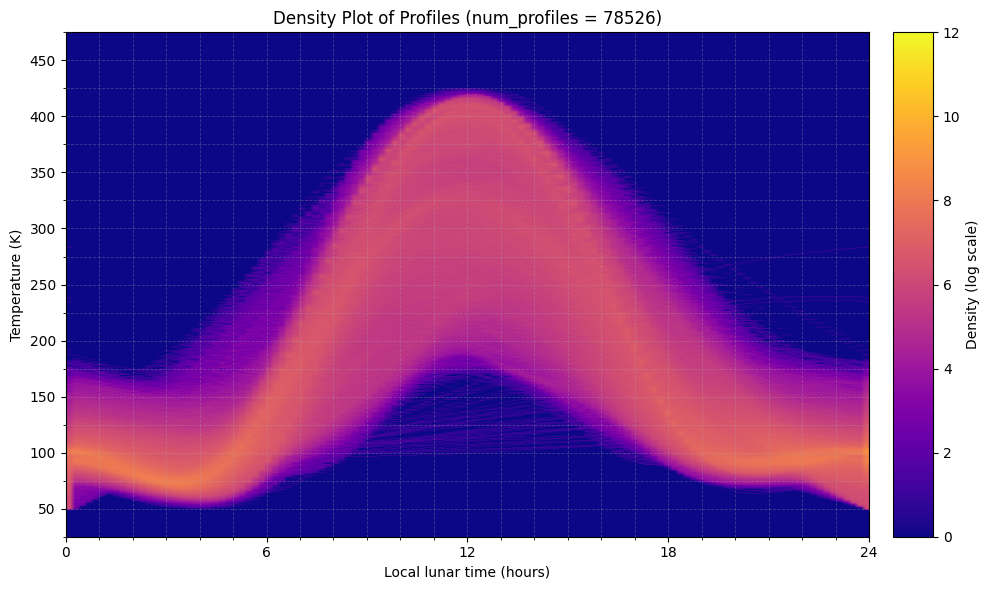

In [7]:
# * * * * * * * * * * * * * * * *
# Generate Density Plot
# * * * * * * * * * * * * * * * *
GenerateDensityPlot(temp_data, model_dir)

In [8]:
# * * * * * * * * * * * * * * * *
# Load Original Profile List
# * * * * * * * * * * * * * * * *
original_profile_list = LoadProfileList(ORIGINAL_PROFILE_LIST_JSON)

Saved figure to /workspace/outputs/profiles_v1_experiment_6_20250331_0257/histogram_max_temp.png


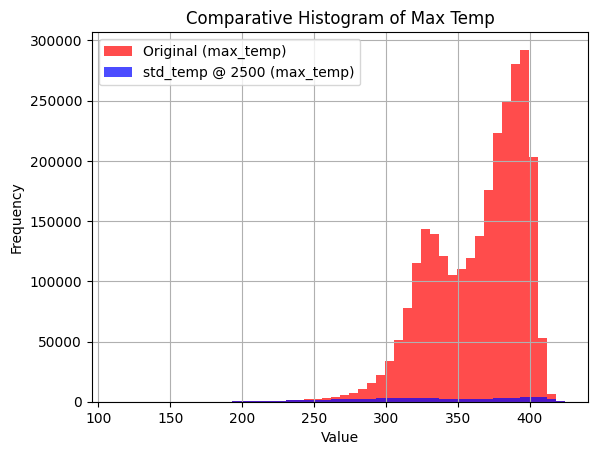

Saved figure to /workspace/outputs/profiles_v1_experiment_6_20250331_0257/histogram_min_temp.png


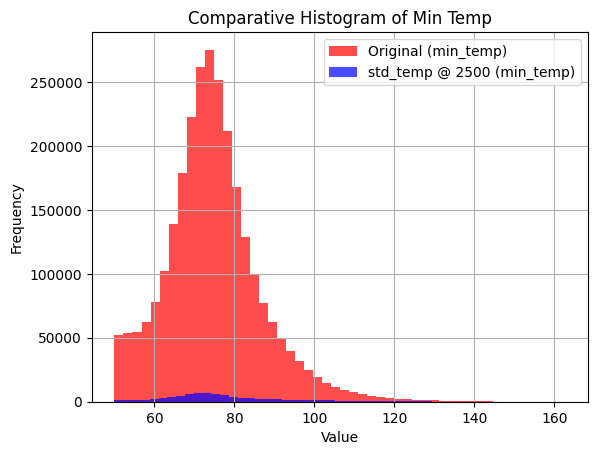

Saved figure to /workspace/outputs/profiles_v1_experiment_6_20250331_0257/histogram_mean_temp.png


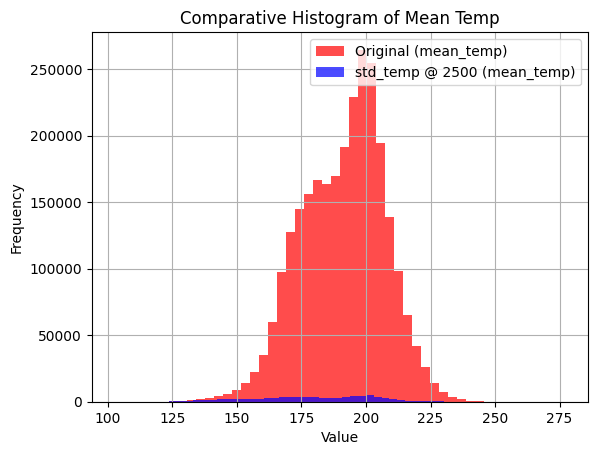

Saved figure to /workspace/outputs/profiles_v1_experiment_6_20250331_0257/histogram_std_temp.png


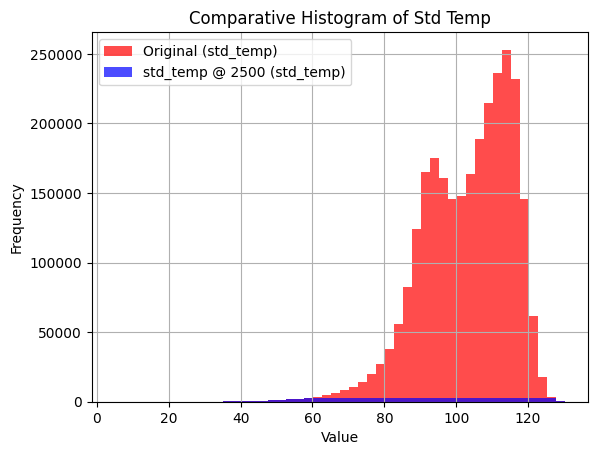

In [9]:
# * * * * * * * * * * * * * * * *
# Generate Histograms
# * * * * * * * * * * * * * * * *
statistics_original = CollectStatisticsFromProfilesV1(PROFILES_DIR, original_profile_list)
statistics_subset = CollectStatisticsFromProfilesV1(PROFILES_DIR, profile_list)
PlotComparativeHistograms(statistics_original, statistics_subset, labels=("Original", f"{TARGET_METRIC} @ {SAMPLE_SIZE}"), output_dir=model_dir)

In [10]:
# * * * * * * * * * * * * * * * *
# Training Log
# * * * * * * * * * * * * * * * 
log_filepath = os.path.join(model_dir, 'training.log')

# * * * * * * * * * * * * * * * *
# Data Prep
# * * * * * * * * * * * * * * * *
x_data_mean, x_data_std, x_data_min, x_data_max = GetDataMetrics(temp_data)

PrintAndLog(log_filepath, "Data Metrics:\n")
PrintAndLog(log_filepath, f"\tMean: {x_data_mean:.4f}\n")
PrintAndLog(log_filepath, f"\tSTD: {x_data_std:.4f}\n")
PrintAndLog(log_filepath, f"\tMin Temp: {x_data_min:.4f}\n")
PrintAndLog(log_filepath, f"\tMax Temp: {x_data_max:.4f}\n")

# Normalize Data (Mean=0, STD=1)
scaler = StandardScaler()
train_loader, val_loader, test_loader = SplitAndNormalizeData(
	temp_data, scaler, BATCH_SIZE, DEVICE)

PrintAndLog(log_filepath, "Datasets:\n")
PrintAndLog(
	log_filepath,
	f"\tTraining Data: {len(train_loader.dataset)}\n")
PrintAndLog(
	log_filepath,
	f"\tValidation Data: {len(val_loader.dataset)}\n")
PrintAndLog(log_filepath, f"\tTest Data: {len(test_loader.dataset)}\n")

Data Metrics:
Mean: 178.8849
STD: 94.4507
Min Temp: 50.0020
Max Temp: 424.6720
Datasets:
Training Data: 54968
Validation Data: 15705
Test Data: 7853


In [11]:
# * * * * * * * * * * * * * * * *
# VAE Setup
# * * * * * * * * * * * * * * * *
vae = VAE(latent_dim=LATENT_DIM).to(DEVICE)
optimizer = optim.Adam(vae.parameters(), lr=LEARNING_RATE, weight_decay=0)
scheduler = ExponentialLR(optimizer, gamma=GAMMA)

summary(vae, input_size=(BATCH_SIZE, INPUT_DIM[0], INPUT_DIM[1]))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [200, 1, 120]             --
├─Encoder: 1-1                           [200, 4, 1]               --
│    └─Wrap1d: 2-1                       [200, 1, 122]             --
│    └─ConstantPad1d: 2-2                [200, 1, 128]             --
│    └─Conv1d: 2-3                       [200, 32, 128]            128
│    └─BatchNorm1d: 2-4                  [200, 32, 128]            64
│    └─Conv1d: 2-5                       [200, 32, 64]             2,080
│    └─BatchNorm1d: 2-6                  [200, 32, 64]             64
│    └─Conv1d: 2-7                       [200, 32, 32]             2,080
│    └─BatchNorm1d: 2-8                  [200, 32, 32]             64
│    └─Conv1d: 2-9                       [200, 32, 16]             2,080
│    └─BatchNorm1d: 2-10                 [200, 32, 16]             64
│    └─Conv1d: 2-11                      [200, 32, 8]              2,080
│ 

In [12]:
# * * * * * * * * * * * * * * * *
# Train and Validate
# * * * * * * * * * * * * * * * *
losses = train(
	vae, train_loader, val_loader,
	optimizer, scheduler, DEVICE, EPOCHS,
	BETA, model_dir)

[Training] Epoch 1/100: 100%|██████████| 275/275 [00:08<00:00, 31.69it/s, best_loss=0.5946]


[Training] Epoch 1/100, L1 Loss: 0.6348, L2 Loss: 0.6510, KL Loss: 0.4637, LR: 0.001000


[Validation] Epoch 1/100: 100%|██████████| 79/79 [00:00<00:00, 113.11it/s]


[Validation] Epoch 1/100, Val L1 Loss: 0.5494, Val L2 Loss: 0.5195, Val KL Loss: 0.6243
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v1_experiment_6_20250331_0257'


[Training] Epoch 2/100: 100%|██████████| 275/275 [00:08<00:00, 31.85it/s, best_loss=0.5964]


[Training] Epoch 2/100, L1 Loss: 0.5790, L2 Loss: 0.5573, KL Loss: 0.5775, LR: 0.000100


[Validation] Epoch 2/100: 100%|██████████| 79/79 [00:01<00:00, 78.73it/s] 


[Validation] Epoch 2/100, Val L1 Loss: 0.5399, Val L2 Loss: 0.5115, Val KL Loss: 0.5941
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v1_experiment_6_20250331_0257'


[Training] Epoch 3/100: 100%|██████████| 275/275 [00:08<00:00, 31.65it/s, best_loss=0.5859]


[Training] Epoch 3/100, L1 Loss: 0.5753, L2 Loss: 0.5526, KL Loss: 0.5840, LR: 0.000010


[Validation] Epoch 3/100: 100%|██████████| 79/79 [00:00<00:00, 106.07it/s]


[Validation] Epoch 3/100, Val L1 Loss: 0.5383, Val L2 Loss: 0.5100, Val KL Loss: 0.5973
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v1_experiment_6_20250331_0257'


[Training] Epoch 4/100: 100%|██████████| 275/275 [00:08<00:00, 31.84it/s, best_loss=0.5893]


[Training] Epoch 4/100, L1 Loss: 0.5759, L2 Loss: 0.5535, KL Loss: 0.5834, LR: 0.000001


[Validation] Epoch 4/100: 100%|██████████| 79/79 [00:00<00:00, 113.51it/s]


[Validation] Epoch 4/100, Val L1 Loss: 0.5373, Val L2 Loss: 0.5090, Val KL Loss: 0.5990
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v1_experiment_6_20250331_0257'


[Training] Epoch 5/100: 100%|██████████| 275/275 [00:08<00:00, 32.04it/s, best_loss=0.5627]


[Training] Epoch 5/100, L1 Loss: 0.5757, L2 Loss: 0.5526, KL Loss: 0.5834, LR: 0.000000


[Validation] Epoch 5/100: 100%|██████████| 79/79 [00:00<00:00, 112.68it/s]


[Validation] Epoch 5/100, Val L1 Loss: 0.5384, Val L2 Loss: 0.5103, Val KL Loss: 0.5937


[Training] Epoch 6/100: 100%|██████████| 275/275 [00:08<00:00, 31.26it/s, best_loss=0.5787]


[Training] Epoch 6/100, L1 Loss: 0.5761, L2 Loss: 0.5534, KL Loss: 0.5834, LR: 0.000000


[Validation] Epoch 6/100: 100%|██████████| 79/79 [00:00<00:00, 107.98it/s]


[Validation] Epoch 6/100, Val L1 Loss: 0.5425, Val L2 Loss: 0.5136, Val KL Loss: 0.5867


[Training] Epoch 7/100: 100%|██████████| 275/275 [00:08<00:00, 31.93it/s, best_loss=0.5838]


[Training] Epoch 7/100, L1 Loss: 0.5756, L2 Loss: 0.5527, KL Loss: 0.5834, LR: 0.000000


[Validation] Epoch 7/100: 100%|██████████| 79/79 [00:00<00:00, 115.49it/s]


[Validation] Epoch 7/100, Val L1 Loss: 0.5384, Val L2 Loss: 0.5101, Val KL Loss: 0.6018


[Training] Epoch 8/100: 100%|██████████| 275/275 [00:08<00:00, 31.30it/s, best_loss=0.5723]


[Training] Epoch 8/100, L1 Loss: 0.5759, L2 Loss: 0.5534, KL Loss: 0.5835, LR: 0.000000


[Validation] Epoch 8/100: 100%|██████████| 79/79 [00:00<00:00, 103.80it/s]


[Validation] Epoch 8/100, Val L1 Loss: 0.5435, Val L2 Loss: 0.5148, Val KL Loss: 0.5819


[Training] Epoch 9/100: 100%|██████████| 275/275 [00:08<00:00, 32.08it/s, best_loss=0.5816]


[Training] Epoch 9/100, L1 Loss: 0.5757, L2 Loss: 0.5532, KL Loss: 0.5835, LR: 0.000000


[Validation] Epoch 9/100: 100%|██████████| 79/79 [00:00<00:00, 109.92it/s]


[Validation] Epoch 9/100, Val L1 Loss: 0.5411, Val L2 Loss: 0.5124, Val KL Loss: 0.5866


[Training] Epoch 10/100: 100%|██████████| 275/275 [00:08<00:00, 31.25it/s, best_loss=0.5880]


[Training] Epoch 10/100, L1 Loss: 0.5761, L2 Loss: 0.5534, KL Loss: 0.5835, LR: 0.000000


[Validation] Epoch 10/100: 100%|██████████| 79/79 [00:00<00:00, 104.24it/s]


[Validation] Epoch 10/100, Val L1 Loss: 0.5410, Val L2 Loss: 0.5124, Val KL Loss: 0.5887


[Training] Epoch 11/100: 100%|██████████| 275/275 [00:08<00:00, 32.07it/s, best_loss=0.5761]


[Training] Epoch 11/100, L1 Loss: 0.5761, L2 Loss: 0.5533, KL Loss: 0.5836, LR: 0.000000


[Validation] Epoch 11/100: 100%|██████████| 79/79 [00:00<00:00, 102.87it/s]


[Validation] Epoch 11/100, Val L1 Loss: 0.5340, Val L2 Loss: 0.5066, Val KL Loss: 0.6047
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v1_experiment_6_20250331_0257'


[Training] Epoch 12/100: 100%|██████████| 275/275 [00:08<00:00, 31.42it/s, best_loss=0.5948]


[Training] Epoch 12/100, L1 Loss: 0.5760, L2 Loss: 0.5530, KL Loss: 0.5835, LR: 0.000000


[Validation] Epoch 12/100: 100%|██████████| 79/79 [00:00<00:00, 104.81it/s]


[Validation] Epoch 12/100, Val L1 Loss: 0.5449, Val L2 Loss: 0.5162, Val KL Loss: 0.5794


[Training] Epoch 13/100: 100%|██████████| 275/275 [00:08<00:00, 31.71it/s, best_loss=0.5934]


[Training] Epoch 13/100, L1 Loss: 0.5756, L2 Loss: 0.5528, KL Loss: 0.5835, LR: 0.000000


[Validation] Epoch 13/100: 100%|██████████| 79/79 [00:00<00:00, 85.44it/s] 


[Validation] Epoch 13/100, Val L1 Loss: 0.5391, Val L2 Loss: 0.5103, Val KL Loss: 0.5941


[Training] Epoch 14/100: 100%|██████████| 275/275 [00:08<00:00, 32.35it/s, best_loss=0.5967]


[Training] Epoch 14/100, L1 Loss: 0.5753, L2 Loss: 0.5526, KL Loss: 0.5835, LR: 0.000000


[Validation] Epoch 14/100: 100%|██████████| 79/79 [00:00<00:00, 113.98it/s]


[Validation] Epoch 14/100, Val L1 Loss: 0.5419, Val L2 Loss: 0.5128, Val KL Loss: 0.5938


[Training] Epoch 15/100: 100%|██████████| 275/275 [00:08<00:00, 32.21it/s, best_loss=0.5910]


[Training] Epoch 15/100, L1 Loss: 0.5760, L2 Loss: 0.5534, KL Loss: 0.5833, LR: 0.000000


[Validation] Epoch 15/100: 100%|██████████| 79/79 [00:00<00:00, 112.50it/s]


[Validation] Epoch 15/100, Val L1 Loss: 0.5373, Val L2 Loss: 0.5095, Val KL Loss: 0.5939


[Training] Epoch 16/100: 100%|██████████| 275/275 [00:08<00:00, 31.54it/s, best_loss=0.5780]


[Training] Epoch 16/100, L1 Loss: 0.5749, L2 Loss: 0.5520, KL Loss: 0.5834, LR: 0.000000


[Validation] Epoch 16/100: 100%|██████████| 79/79 [00:00<00:00, 108.81it/s]


[Validation] Epoch 16/100, Val L1 Loss: 0.5412, Val L2 Loss: 0.5131, Val KL Loss: 0.5853


[Training] Epoch 17/100: 100%|██████████| 275/275 [00:08<00:00, 31.87it/s, best_loss=0.5846]


[Training] Epoch 17/100, L1 Loss: 0.5759, L2 Loss: 0.5530, KL Loss: 0.5835, LR: 0.000000


[Validation] Epoch 17/100: 100%|██████████| 79/79 [00:00<00:00, 112.63it/s]


[Validation] Epoch 17/100, Val L1 Loss: 0.5389, Val L2 Loss: 0.5103, Val KL Loss: 0.5940


[Training] Epoch 18/100: 100%|██████████| 275/275 [00:08<00:00, 31.94it/s, best_loss=0.5819]


[Training] Epoch 18/100, L1 Loss: 0.5756, L2 Loss: 0.5528, KL Loss: 0.5834, LR: 0.000000


[Validation] Epoch 18/100: 100%|██████████| 79/79 [00:00<00:00, 120.59it/s]


[Validation] Epoch 18/100, Val L1 Loss: 0.5401, Val L2 Loss: 0.5124, Val KL Loss: 0.5918


[Training] Epoch 19/100: 100%|██████████| 275/275 [00:08<00:00, 33.12it/s, best_loss=0.5831]


[Training] Epoch 19/100, L1 Loss: 0.5761, L2 Loss: 0.5534, KL Loss: 0.5835, LR: 0.000000


[Validation] Epoch 19/100: 100%|██████████| 79/79 [00:00<00:00, 107.45it/s]


[Validation] Epoch 19/100, Val L1 Loss: 0.5387, Val L2 Loss: 0.5107, Val KL Loss: 0.5983


[Training] Epoch 20/100: 100%|██████████| 275/275 [00:08<00:00, 32.59it/s, best_loss=0.5762]


[Training] Epoch 20/100, L1 Loss: 0.5757, L2 Loss: 0.5528, KL Loss: 0.5835, LR: 0.000000


[Validation] Epoch 20/100: 100%|██████████| 79/79 [00:00<00:00, 104.17it/s]


[Validation] Epoch 20/100, Val L1 Loss: 0.5409, Val L2 Loss: 0.5121, Val KL Loss: 0.5914


[Training] Epoch 21/100: 100%|██████████| 275/275 [00:08<00:00, 31.64it/s, best_loss=0.5877]


[Training] Epoch 21/100, L1 Loss: 0.5752, L2 Loss: 0.5525, KL Loss: 0.5834, LR: 0.000000


[Validation] Epoch 21/100: 100%|██████████| 79/79 [00:00<00:00, 112.40it/s]


[Validation] Epoch 21/100, Val L1 Loss: 0.5413, Val L2 Loss: 0.5123, Val KL Loss: 0.5872


[Training] Epoch 22/100: 100%|██████████| 275/275 [00:08<00:00, 33.04it/s, best_loss=0.5864]


[Training] Epoch 22/100, L1 Loss: 0.5756, L2 Loss: 0.5529, KL Loss: 0.5834, LR: 0.000000


[Validation] Epoch 22/100: 100%|██████████| 79/79 [00:00<00:00, 119.22it/s]


[Validation] Epoch 22/100, Val L1 Loss: 0.5376, Val L2 Loss: 0.5097, Val KL Loss: 0.5932


[Training] Epoch 23/100: 100%|██████████| 275/275 [00:08<00:00, 31.96it/s, best_loss=0.5764]


[Training] Epoch 23/100, L1 Loss: 0.5756, L2 Loss: 0.5529, KL Loss: 0.5835, LR: 0.000000


[Validation] Epoch 23/100: 100%|██████████| 79/79 [00:00<00:00, 111.33it/s]


[Validation] Epoch 23/100, Val L1 Loss: 0.5396, Val L2 Loss: 0.5108, Val KL Loss: 0.5952


[Training] Epoch 24/100: 100%|██████████| 275/275 [00:08<00:00, 32.23it/s, best_loss=0.5977]


[Training] Epoch 24/100, L1 Loss: 0.5759, L2 Loss: 0.5531, KL Loss: 0.5833, LR: 0.000000


[Validation] Epoch 24/100: 100%|██████████| 79/79 [00:00<00:00, 88.55it/s] 


[Validation] Epoch 24/100, Val L1 Loss: 0.5394, Val L2 Loss: 0.5111, Val KL Loss: 0.5893


[Training] Epoch 25/100: 100%|██████████| 275/275 [00:08<00:00, 32.06it/s, best_loss=0.5790]


[Training] Epoch 25/100, L1 Loss: 0.5754, L2 Loss: 0.5526, KL Loss: 0.5836, LR: 0.000000


[Validation] Epoch 25/100: 100%|██████████| 79/79 [00:00<00:00, 104.70it/s]


[Validation] Epoch 25/100, Val L1 Loss: 0.5398, Val L2 Loss: 0.5113, Val KL Loss: 0.5901


[Training] Epoch 26/100: 100%|██████████| 275/275 [00:08<00:00, 32.03it/s, best_loss=0.5808]


[Training] Epoch 26/100, L1 Loss: 0.5752, L2 Loss: 0.5527, KL Loss: 0.5834, LR: 0.000000


[Validation] Epoch 26/100: 100%|██████████| 79/79 [00:00<00:00, 107.05it/s]


[Validation] Epoch 26/100, Val L1 Loss: 0.5391, Val L2 Loss: 0.5107, Val KL Loss: 0.5973


[Training] Epoch 27/100: 100%|██████████| 275/275 [00:08<00:00, 33.52it/s, best_loss=0.5951]


[Training] Epoch 27/100, L1 Loss: 0.5755, L2 Loss: 0.5528, KL Loss: 0.5834, LR: 0.000000


[Validation] Epoch 27/100: 100%|██████████| 79/79 [00:00<00:00, 108.15it/s]


[Validation] Epoch 27/100, Val L1 Loss: 0.5419, Val L2 Loss: 0.5129, Val KL Loss: 0.5870


[Training] Epoch 28/100: 100%|██████████| 275/275 [00:09<00:00, 30.49it/s, best_loss=0.5878]


[Training] Epoch 28/100, L1 Loss: 0.5756, L2 Loss: 0.5532, KL Loss: 0.5834, LR: 0.000000


[Validation] Epoch 28/100: 100%|██████████| 79/79 [00:00<00:00, 110.47it/s]


[Validation] Epoch 28/100, Val L1 Loss: 0.5394, Val L2 Loss: 0.5110, Val KL Loss: 0.5915


[Training] Epoch 29/100: 100%|██████████| 275/275 [00:08<00:00, 32.75it/s, best_loss=0.5793]


[Training] Epoch 29/100, L1 Loss: 0.5755, L2 Loss: 0.5526, KL Loss: 0.5835, LR: 0.000000


[Validation] Epoch 29/100: 100%|██████████| 79/79 [00:00<00:00, 117.90it/s]


[Validation] Epoch 29/100, Val L1 Loss: 0.5426, Val L2 Loss: 0.5137, Val KL Loss: 0.5842


[Training] Epoch 30/100: 100%|██████████| 275/275 [00:08<00:00, 32.47it/s, best_loss=0.5795]


[Training] Epoch 30/100, L1 Loss: 0.5758, L2 Loss: 0.5530, KL Loss: 0.5835, LR: 0.000000


[Validation] Epoch 30/100: 100%|██████████| 79/79 [00:00<00:00, 115.59it/s]


[Validation] Epoch 30/100, Val L1 Loss: 0.5374, Val L2 Loss: 0.5091, Val KL Loss: 0.5983


[Training] Epoch 31/100: 100%|██████████| 275/275 [00:08<00:00, 32.02it/s, best_loss=0.5804]


[Training] Epoch 31/100, L1 Loss: 0.5756, L2 Loss: 0.5528, KL Loss: 0.5834, LR: 0.000000


[Validation] Epoch 31/100: 100%|██████████| 79/79 [00:00<00:00, 111.70it/s]


[Validation] Epoch 31/100, Val L1 Loss: 0.5417, Val L2 Loss: 0.5130, Val KL Loss: 0.5862


[Training] Epoch 32/100: 100%|██████████| 275/275 [00:08<00:00, 31.57it/s, best_loss=0.5844]


[Training] Epoch 32/100, L1 Loss: 0.5754, L2 Loss: 0.5524, KL Loss: 0.5834, LR: 0.000000


[Validation] Epoch 32/100: 100%|██████████| 79/79 [00:00<00:00, 108.63it/s]


[Validation] Epoch 32/100, Val L1 Loss: 0.5371, Val L2 Loss: 0.5090, Val KL Loss: 0.6024


[Training] Epoch 33/100: 100%|██████████| 275/275 [00:08<00:00, 32.83it/s, best_loss=0.5660]


[Training] Epoch 33/100, L1 Loss: 0.5755, L2 Loss: 0.5528, KL Loss: 0.5835, LR: 0.000000


[Validation] Epoch 33/100: 100%|██████████| 79/79 [00:00<00:00, 114.25it/s]


[Validation] Epoch 33/100, Val L1 Loss: 0.5437, Val L2 Loss: 0.5144, Val KL Loss: 0.5847


[Training] Epoch 34/100: 100%|██████████| 275/275 [00:08<00:00, 31.68it/s, best_loss=0.5774]


[Training] Epoch 34/100, L1 Loss: 0.5753, L2 Loss: 0.5526, KL Loss: 0.5835, LR: 0.000000


[Validation] Epoch 34/100: 100%|██████████| 79/79 [00:00<00:00, 112.24it/s]


[Validation] Epoch 34/100, Val L1 Loss: 0.5365, Val L2 Loss: 0.5091, Val KL Loss: 0.5963


[Training] Epoch 35/100: 100%|██████████| 275/275 [00:08<00:00, 31.74it/s, best_loss=0.5858]


[Training] Epoch 35/100, L1 Loss: 0.5752, L2 Loss: 0.5521, KL Loss: 0.5835, LR: 0.000000


[Validation] Epoch 35/100: 100%|██████████| 79/79 [00:00<00:00, 83.56it/s] 


[Validation] Epoch 35/100, Val L1 Loss: 0.5385, Val L2 Loss: 0.5101, Val KL Loss: 0.5969


[Training] Epoch 36/100: 100%|██████████| 275/275 [00:08<00:00, 32.03it/s, best_loss=0.5491]


[Training] Epoch 36/100, L1 Loss: 0.5756, L2 Loss: 0.5527, KL Loss: 0.5834, LR: 0.000000


[Validation] Epoch 36/100: 100%|██████████| 79/79 [00:00<00:00, 111.35it/s]


[Validation] Epoch 36/100, Val L1 Loss: 0.5378, Val L2 Loss: 0.5096, Val KL Loss: 0.6002


[Training] Epoch 37/100: 100%|██████████| 275/275 [00:08<00:00, 32.61it/s, best_loss=0.5878]


[Training] Epoch 37/100, L1 Loss: 0.5757, L2 Loss: 0.5533, KL Loss: 0.5835, LR: 0.000000


[Validation] Epoch 37/100: 100%|██████████| 79/79 [00:00<00:00, 116.17it/s]


[Validation] Epoch 37/100, Val L1 Loss: 0.5390, Val L2 Loss: 0.5107, Val KL Loss: 0.5894


[Training] Epoch 38/100: 100%|██████████| 275/275 [00:08<00:00, 31.98it/s, best_loss=0.5997]


[Training] Epoch 38/100, L1 Loss: 0.5757, L2 Loss: 0.5530, KL Loss: 0.5835, LR: 0.000000


[Validation] Epoch 38/100: 100%|██████████| 79/79 [00:00<00:00, 93.64it/s]


[Validation] Epoch 38/100, Val L1 Loss: 0.5387, Val L2 Loss: 0.5099, Val KL Loss: 0.5942


[Training] Epoch 39/100: 100%|██████████| 275/275 [00:08<00:00, 31.37it/s, best_loss=0.5767]


[Training] Epoch 39/100, L1 Loss: 0.5753, L2 Loss: 0.5525, KL Loss: 0.5835, LR: 0.000000


[Validation] Epoch 39/100: 100%|██████████| 79/79 [00:00<00:00, 109.20it/s]


[Validation] Epoch 39/100, Val L1 Loss: 0.5416, Val L2 Loss: 0.5130, Val KL Loss: 0.5892


[Training] Epoch 40/100: 100%|██████████| 275/275 [00:08<00:00, 32.09it/s, best_loss=0.5997]


[Training] Epoch 40/100, L1 Loss: 0.5755, L2 Loss: 0.5528, KL Loss: 0.5833, LR: 0.000000


[Validation] Epoch 40/100: 100%|██████████| 79/79 [00:00<00:00, 109.59it/s]


[Validation] Epoch 40/100, Val L1 Loss: 0.5389, Val L2 Loss: 0.5104, Val KL Loss: 0.5957


[Training] Epoch 41/100: 100%|██████████| 275/275 [00:08<00:00, 31.81it/s, best_loss=0.5573]


[Training] Epoch 41/100, L1 Loss: 0.5761, L2 Loss: 0.5534, KL Loss: 0.5834, LR: 0.000000


[Validation] Epoch 41/100: 100%|██████████| 79/79 [00:00<00:00, 113.82it/s]


[Validation] Epoch 41/100, Val L1 Loss: 0.5393, Val L2 Loss: 0.5104, Val KL Loss: 0.5937


[Training] Epoch 42/100: 100%|██████████| 275/275 [00:08<00:00, 32.43it/s, best_loss=0.5892]


[Training] Epoch 42/100, L1 Loss: 0.5756, L2 Loss: 0.5529, KL Loss: 0.5835, LR: 0.000000


[Validation] Epoch 42/100: 100%|██████████| 79/79 [00:00<00:00, 114.08it/s]


[Validation] Epoch 42/100, Val L1 Loss: 0.5412, Val L2 Loss: 0.5127, Val KL Loss: 0.5843


[Training] Epoch 43/100: 100%|██████████| 275/275 [00:08<00:00, 31.36it/s, best_loss=0.5891]


[Training] Epoch 43/100, L1 Loss: 0.5750, L2 Loss: 0.5521, KL Loss: 0.5835, LR: 0.000000


[Validation] Epoch 43/100: 100%|██████████| 79/79 [00:00<00:00, 109.03it/s]


[Validation] Epoch 43/100, Val L1 Loss: 0.5371, Val L2 Loss: 0.5092, Val KL Loss: 0.5935


[Training] Epoch 44/100: 100%|██████████| 275/275 [00:08<00:00, 31.74it/s, best_loss=0.5670]


[Training] Epoch 44/100, L1 Loss: 0.5758, L2 Loss: 0.5529, KL Loss: 0.5834, LR: 0.000000


[Validation] Epoch 44/100: 100%|██████████| 79/79 [00:00<00:00, 108.80it/s]


[Validation] Epoch 44/100, Val L1 Loss: 0.5415, Val L2 Loss: 0.5128, Val KL Loss: 0.5847


[Training] Epoch 45/100: 100%|██████████| 275/275 [00:08<00:00, 32.80it/s, best_loss=0.5991]


[Training] Epoch 45/100, L1 Loss: 0.5754, L2 Loss: 0.5529, KL Loss: 0.5835, LR: 0.000000


[Validation] Epoch 45/100: 100%|██████████| 79/79 [00:00<00:00, 105.42it/s]


[Validation] Epoch 45/100, Val L1 Loss: 0.5412, Val L2 Loss: 0.5121, Val KL Loss: 0.5975


[Training] Epoch 46/100: 100%|██████████| 275/275 [00:08<00:00, 31.95it/s, best_loss=0.5838]


[Training] Epoch 46/100, L1 Loss: 0.5751, L2 Loss: 0.5523, KL Loss: 0.5835, LR: 0.000000


[Validation] Epoch 46/100: 100%|██████████| 79/79 [00:00<00:00, 82.43it/s] 


[Validation] Epoch 46/100, Val L1 Loss: 0.5391, Val L2 Loss: 0.5106, Val KL Loss: 0.5962


[Training] Epoch 47/100: 100%|██████████| 275/275 [00:08<00:00, 32.50it/s, best_loss=0.5717]


[Training] Epoch 47/100, L1 Loss: 0.5754, L2 Loss: 0.5524, KL Loss: 0.5836, LR: 0.000000


[Validation] Epoch 47/100: 100%|██████████| 79/79 [00:00<00:00, 114.96it/s]


[Validation] Epoch 47/100, Val L1 Loss: 0.5412, Val L2 Loss: 0.5124, Val KL Loss: 0.5849


[Training] Epoch 48/100: 100%|██████████| 275/275 [00:08<00:00, 32.24it/s, best_loss=0.5599]


[Training] Epoch 48/100, L1 Loss: 0.5757, L2 Loss: 0.5529, KL Loss: 0.5833, LR: 0.000000


[Validation] Epoch 48/100: 100%|██████████| 79/79 [00:00<00:00, 116.59it/s]


[Validation] Epoch 48/100, Val L1 Loss: 0.5438, Val L2 Loss: 0.5143, Val KL Loss: 0.5789


[Training] Epoch 49/100: 100%|██████████| 275/275 [00:08<00:00, 31.88it/s, best_loss=0.5730]


[Training] Epoch 49/100, L1 Loss: 0.5760, L2 Loss: 0.5533, KL Loss: 0.5835, LR: 0.000000


[Validation] Epoch 49/100: 100%|██████████| 79/79 [00:00<00:00, 104.27it/s]


[Validation] Epoch 49/100, Val L1 Loss: 0.5383, Val L2 Loss: 0.5098, Val KL Loss: 0.5997


[Training] Epoch 50/100: 100%|██████████| 275/275 [00:08<00:00, 31.17it/s, best_loss=0.5911]


[Training] Epoch 50/100, L1 Loss: 0.5758, L2 Loss: 0.5533, KL Loss: 0.5835, LR: 0.000000


[Validation] Epoch 50/100: 100%|██████████| 79/79 [00:00<00:00, 107.64it/s]


[Validation] Epoch 50/100, Val L1 Loss: 0.5388, Val L2 Loss: 0.5114, Val KL Loss: 0.5867


[Training] Epoch 51/100: 100%|██████████| 275/275 [00:08<00:00, 31.93it/s, best_loss=0.5731]


[Training] Epoch 51/100, L1 Loss: 0.5756, L2 Loss: 0.5530, KL Loss: 0.5834, LR: 0.000000


[Validation] Epoch 51/100: 100%|██████████| 79/79 [00:00<00:00, 118.20it/s]


[Validation] Epoch 51/100, Val L1 Loss: 0.5429, Val L2 Loss: 0.5139, Val KL Loss: 0.5816


[Training] Epoch 52/100: 100%|██████████| 275/275 [00:08<00:00, 32.96it/s, best_loss=0.5851]


[Training] Epoch 52/100, L1 Loss: 0.5753, L2 Loss: 0.5527, KL Loss: 0.5834, LR: 0.000000


[Validation] Epoch 52/100: 100%|██████████| 79/79 [00:00<00:00, 116.03it/s]


[Validation] Epoch 52/100, Val L1 Loss: 0.5389, Val L2 Loss: 0.5104, Val KL Loss: 0.5946


[Training] Epoch 53/100: 100%|██████████| 275/275 [00:08<00:00, 33.55it/s, best_loss=0.5905]


[Training] Epoch 53/100, L1 Loss: 0.5760, L2 Loss: 0.5532, KL Loss: 0.5834, LR: 0.000000


[Validation] Epoch 53/100: 100%|██████████| 79/79 [00:00<00:00, 117.76it/s]


[Validation] Epoch 53/100, Val L1 Loss: 0.5401, Val L2 Loss: 0.5115, Val KL Loss: 0.5899


[Training] Epoch 54/100: 100%|██████████| 275/275 [00:08<00:00, 31.42it/s, best_loss=0.5899]


[Training] Epoch 54/100, L1 Loss: 0.5759, L2 Loss: 0.5532, KL Loss: 0.5835, LR: 0.000000


[Validation] Epoch 54/100: 100%|██████████| 79/79 [00:00<00:00, 118.12it/s]


[Validation] Epoch 54/100, Val L1 Loss: 0.5420, Val L2 Loss: 0.5131, Val KL Loss: 0.5867


[Training] Epoch 55/100: 100%|██████████| 275/275 [00:08<00:00, 31.89it/s, best_loss=0.5965]


[Training] Epoch 55/100, L1 Loss: 0.5759, L2 Loss: 0.5533, KL Loss: 0.5835, LR: 0.000000


[Validation] Epoch 55/100: 100%|██████████| 79/79 [00:00<00:00, 110.49it/s]


[Validation] Epoch 55/100, Val L1 Loss: 0.5396, Val L2 Loss: 0.5113, Val KL Loss: 0.5907


[Training] Epoch 56/100: 100%|██████████| 275/275 [00:08<00:00, 32.55it/s, best_loss=0.6001]


[Training] Epoch 56/100, L1 Loss: 0.5759, L2 Loss: 0.5535, KL Loss: 0.5835, LR: 0.000000


[Validation] Epoch 56/100: 100%|██████████| 79/79 [00:00<00:00, 113.89it/s]


[Validation] Epoch 56/100, Val L1 Loss: 0.5427, Val L2 Loss: 0.5142, Val KL Loss: 0.5825


[Training] Epoch 57/100: 100%|██████████| 275/275 [00:08<00:00, 32.71it/s, best_loss=0.5821]


[Training] Epoch 57/100, L1 Loss: 0.5759, L2 Loss: 0.5533, KL Loss: 0.5834, LR: 0.000000


[Validation] Epoch 57/100: 100%|██████████| 79/79 [00:00<00:00, 116.96it/s]


[Validation] Epoch 57/100, Val L1 Loss: 0.5430, Val L2 Loss: 0.5139, Val KL Loss: 0.5844


[Training] Epoch 58/100: 100%|██████████| 275/275 [00:08<00:00, 33.00it/s, best_loss=0.5856]


[Training] Epoch 58/100, L1 Loss: 0.5752, L2 Loss: 0.5523, KL Loss: 0.5833, LR: 0.000000


[Validation] Epoch 58/100: 100%|██████████| 79/79 [00:00<00:00, 111.54it/s]


[Validation] Epoch 58/100, Val L1 Loss: 0.5425, Val L2 Loss: 0.5137, Val KL Loss: 0.5845


[Training] Epoch 59/100: 100%|██████████| 275/275 [00:08<00:00, 32.97it/s, best_loss=0.5879]


[Training] Epoch 59/100, L1 Loss: 0.5759, L2 Loss: 0.5534, KL Loss: 0.5835, LR: 0.000000


[Validation] Epoch 59/100: 100%|██████████| 79/79 [00:00<00:00, 113.78it/s]


[Validation] Epoch 59/100, Val L1 Loss: 0.5375, Val L2 Loss: 0.5095, Val KL Loss: 0.5992


[Training] Epoch 60/100: 100%|██████████| 275/275 [00:08<00:00, 32.21it/s, best_loss=0.5831]


[Training] Epoch 60/100, L1 Loss: 0.5754, L2 Loss: 0.5524, KL Loss: 0.5834, LR: 0.000000


[Validation] Epoch 60/100: 100%|██████████| 79/79 [00:00<00:00, 118.24it/s]


[Validation] Epoch 60/100, Val L1 Loss: 0.5388, Val L2 Loss: 0.5105, Val KL Loss: 0.5920


[Training] Epoch 61/100: 100%|██████████| 275/275 [00:08<00:00, 31.35it/s, best_loss=0.5917]


[Training] Epoch 61/100, L1 Loss: 0.5753, L2 Loss: 0.5528, KL Loss: 0.5834, LR: 0.000000


[Validation] Epoch 61/100: 100%|██████████| 79/79 [00:00<00:00, 109.06it/s]


[Validation] Epoch 61/100, Val L1 Loss: 0.5417, Val L2 Loss: 0.5131, Val KL Loss: 0.5846


[Training] Epoch 62/100: 100%|██████████| 275/275 [00:08<00:00, 31.71it/s, best_loss=0.5980]


[Training] Epoch 62/100, L1 Loss: 0.5755, L2 Loss: 0.5527, KL Loss: 0.5835, LR: 0.000000


[Validation] Epoch 62/100: 100%|██████████| 79/79 [00:00<00:00, 116.92it/s]


[Validation] Epoch 62/100, Val L1 Loss: 0.5376, Val L2 Loss: 0.5098, Val KL Loss: 0.5946


[Training] Epoch 63/100: 100%|██████████| 275/275 [00:08<00:00, 31.39it/s, best_loss=0.5832]


[Training] Epoch 63/100, L1 Loss: 0.5755, L2 Loss: 0.5528, KL Loss: 0.5835, LR: 0.000000


[Validation] Epoch 63/100: 100%|██████████| 79/79 [00:00<00:00, 108.77it/s]


[Validation] Epoch 63/100, Val L1 Loss: 0.5356, Val L2 Loss: 0.5077, Val KL Loss: 0.6093


[Training] Epoch 64/100: 100%|██████████| 275/275 [00:08<00:00, 32.06it/s, best_loss=0.5793]


[Training] Epoch 64/100, L1 Loss: 0.5757, L2 Loss: 0.5528, KL Loss: 0.5835, LR: 0.000000


[Validation] Epoch 64/100: 100%|██████████| 79/79 [00:00<00:00, 114.11it/s]


[Validation] Epoch 64/100, Val L1 Loss: 0.5371, Val L2 Loss: 0.5094, Val KL Loss: 0.5957


[Training] Epoch 65/100: 100%|██████████| 275/275 [00:08<00:00, 31.39it/s, best_loss=0.5882]


[Training] Epoch 65/100, L1 Loss: 0.5756, L2 Loss: 0.5530, KL Loss: 0.5834, LR: 0.000000


[Validation] Epoch 65/100: 100%|██████████| 79/79 [00:00<00:00, 110.30it/s]


[Validation] Epoch 65/100, Val L1 Loss: 0.5407, Val L2 Loss: 0.5124, Val KL Loss: 0.5900


[Training] Epoch 66/100: 100%|██████████| 275/275 [00:08<00:00, 31.96it/s, best_loss=0.5762]


[Training] Epoch 66/100, L1 Loss: 0.5755, L2 Loss: 0.5528, KL Loss: 0.5835, LR: 0.000000


[Validation] Epoch 66/100: 100%|██████████| 79/79 [00:00<00:00, 122.04it/s]


[Validation] Epoch 66/100, Val L1 Loss: 0.5408, Val L2 Loss: 0.5121, Val KL Loss: 0.5911


[Training] Epoch 67/100: 100%|██████████| 275/275 [00:08<00:00, 32.56it/s, best_loss=0.6050]


[Training] Epoch 67/100, L1 Loss: 0.5752, L2 Loss: 0.5526, KL Loss: 0.5835, LR: 0.000000


[Validation] Epoch 67/100: 100%|██████████| 79/79 [00:00<00:00, 108.82it/s]


[Validation] Epoch 67/100, Val L1 Loss: 0.5444, Val L2 Loss: 0.5153, Val KL Loss: 0.5810


[Training] Epoch 68/100: 100%|██████████| 275/275 [00:08<00:00, 31.92it/s, best_loss=0.5867]


[Training] Epoch 68/100, L1 Loss: 0.5748, L2 Loss: 0.5519, KL Loss: 0.5834, LR: 0.000000


[Validation] Epoch 68/100: 100%|██████████| 79/79 [00:00<00:00, 110.13it/s]


[Validation] Epoch 68/100, Val L1 Loss: 0.5420, Val L2 Loss: 0.5131, Val KL Loss: 0.5891


[Training] Epoch 69/100: 100%|██████████| 275/275 [00:08<00:00, 31.65it/s, best_loss=0.5867]


[Training] Epoch 69/100, L1 Loss: 0.5755, L2 Loss: 0.5526, KL Loss: 0.5834, LR: 0.000000


[Validation] Epoch 69/100: 100%|██████████| 79/79 [00:00<00:00, 116.04it/s]


[Validation] Epoch 69/100, Val L1 Loss: 0.5412, Val L2 Loss: 0.5126, Val KL Loss: 0.5844


[Training] Epoch 70/100: 100%|██████████| 275/275 [00:08<00:00, 32.11it/s, best_loss=0.5961]


[Training] Epoch 70/100, L1 Loss: 0.5756, L2 Loss: 0.5528, KL Loss: 0.5834, LR: 0.000000


[Validation] Epoch 70/100: 100%|██████████| 79/79 [00:00<00:00, 110.21it/s]


[Validation] Epoch 70/100, Val L1 Loss: 0.5400, Val L2 Loss: 0.5114, Val KL Loss: 0.5915


[Training] Epoch 71/100: 100%|██████████| 275/275 [00:08<00:00, 31.99it/s, best_loss=0.5840]


[Training] Epoch 71/100, L1 Loss: 0.5755, L2 Loss: 0.5527, KL Loss: 0.5835, LR: 0.000000


[Validation] Epoch 71/100: 100%|██████████| 79/79 [00:00<00:00, 112.17it/s]


[Validation] Epoch 71/100, Val L1 Loss: 0.5452, Val L2 Loss: 0.5158, Val KL Loss: 0.5771


[Training] Epoch 72/100: 100%|██████████| 275/275 [00:08<00:00, 31.35it/s, best_loss=0.5782]


[Training] Epoch 72/100, L1 Loss: 0.5756, L2 Loss: 0.5530, KL Loss: 0.5834, LR: 0.000000


[Validation] Epoch 72/100: 100%|██████████| 79/79 [00:00<00:00, 109.21it/s]


[Validation] Epoch 72/100, Val L1 Loss: 0.5377, Val L2 Loss: 0.5099, Val KL Loss: 0.5904


[Training] Epoch 73/100: 100%|██████████| 275/275 [00:08<00:00, 33.00it/s, best_loss=0.5964]


[Training] Epoch 73/100, L1 Loss: 0.5751, L2 Loss: 0.5521, KL Loss: 0.5835, LR: 0.000000


[Validation] Epoch 73/100: 100%|██████████| 79/79 [00:00<00:00, 112.73it/s]


[Validation] Epoch 73/100, Val L1 Loss: 0.5398, Val L2 Loss: 0.5114, Val KL Loss: 0.5869


[Training] Epoch 74/100: 100%|██████████| 275/275 [00:08<00:00, 32.73it/s, best_loss=0.5957]


[Training] Epoch 74/100, L1 Loss: 0.5754, L2 Loss: 0.5525, KL Loss: 0.5835, LR: 0.000000


[Validation] Epoch 74/100: 100%|██████████| 79/79 [00:00<00:00, 108.58it/s]


[Validation] Epoch 74/100, Val L1 Loss: 0.5405, Val L2 Loss: 0.5118, Val KL Loss: 0.5927


[Training] Epoch 75/100: 100%|██████████| 275/275 [00:08<00:00, 32.17it/s, best_loss=0.6003]


[Training] Epoch 75/100, L1 Loss: 0.5757, L2 Loss: 0.5528, KL Loss: 0.5835, LR: 0.000000


[Validation] Epoch 75/100: 100%|██████████| 79/79 [00:00<00:00, 114.67it/s]


[Validation] Epoch 75/100, Val L1 Loss: 0.5394, Val L2 Loss: 0.5109, Val KL Loss: 0.5948


[Training] Epoch 76/100: 100%|██████████| 275/275 [00:08<00:00, 31.99it/s, best_loss=0.5944]


[Training] Epoch 76/100, L1 Loss: 0.5751, L2 Loss: 0.5524, KL Loss: 0.5834, LR: 0.000000


[Validation] Epoch 76/100: 100%|██████████| 79/79 [00:00<00:00, 110.11it/s]


[Validation] Epoch 76/100, Val L1 Loss: 0.5408, Val L2 Loss: 0.5118, Val KL Loss: 0.5959


[Training] Epoch 77/100: 100%|██████████| 275/275 [00:08<00:00, 31.94it/s, best_loss=0.5940]


[Training] Epoch 77/100, L1 Loss: 0.5750, L2 Loss: 0.5523, KL Loss: 0.5835, LR: 0.000000


[Validation] Epoch 77/100: 100%|██████████| 79/79 [00:00<00:00, 114.19it/s]


[Validation] Epoch 77/100, Val L1 Loss: 0.5408, Val L2 Loss: 0.5126, Val KL Loss: 0.5854


[Training] Epoch 78/100: 100%|██████████| 275/275 [00:08<00:00, 31.30it/s, best_loss=0.6011]


[Training] Epoch 78/100, L1 Loss: 0.5758, L2 Loss: 0.5531, KL Loss: 0.5835, LR: 0.000000


[Validation] Epoch 78/100: 100%|██████████| 79/79 [00:00<00:00, 110.12it/s]


[Validation] Epoch 78/100, Val L1 Loss: 0.5365, Val L2 Loss: 0.5089, Val KL Loss: 0.6010


[Training] Epoch 79/100: 100%|██████████| 275/275 [00:08<00:00, 32.22it/s, best_loss=0.5777]


[Training] Epoch 79/100, L1 Loss: 0.5759, L2 Loss: 0.5531, KL Loss: 0.5833, LR: 0.000000


[Validation] Epoch 79/100: 100%|██████████| 79/79 [00:00<00:00, 111.49it/s]


[Validation] Epoch 79/100, Val L1 Loss: 0.5405, Val L2 Loss: 0.5117, Val KL Loss: 0.5926


[Training] Epoch 80/100: 100%|██████████| 275/275 [00:08<00:00, 31.20it/s, best_loss=0.5789]


[Training] Epoch 80/100, L1 Loss: 0.5756, L2 Loss: 0.5528, KL Loss: 0.5835, LR: 0.000000


[Validation] Epoch 80/100: 100%|██████████| 79/79 [00:00<00:00, 112.27it/s]


[Validation] Epoch 80/100, Val L1 Loss: 0.5450, Val L2 Loss: 0.5155, Val KL Loss: 0.5831


[Training] Epoch 81/100: 100%|██████████| 275/275 [00:08<00:00, 31.72it/s, best_loss=0.5894]


[Training] Epoch 81/100, L1 Loss: 0.5754, L2 Loss: 0.5524, KL Loss: 0.5834, LR: 0.000000


[Validation] Epoch 81/100: 100%|██████████| 79/79 [00:00<00:00, 111.66it/s]


[Validation] Epoch 81/100, Val L1 Loss: 0.5368, Val L2 Loss: 0.5090, Val KL Loss: 0.6052


[Training] Epoch 82/100: 100%|██████████| 275/275 [00:08<00:00, 32.06it/s, best_loss=0.5558]


[Training] Epoch 82/100, L1 Loss: 0.5758, L2 Loss: 0.5532, KL Loss: 0.5835, LR: 0.000000


[Validation] Epoch 82/100: 100%|██████████| 79/79 [00:00<00:00, 114.74it/s]


[Validation] Epoch 82/100, Val L1 Loss: 0.5374, Val L2 Loss: 0.5091, Val KL Loss: 0.6044


[Training] Epoch 83/100: 100%|██████████| 275/275 [00:08<00:00, 31.56it/s, best_loss=0.5824]


[Training] Epoch 83/100, L1 Loss: 0.5754, L2 Loss: 0.5525, KL Loss: 0.5834, LR: 0.000000


[Validation] Epoch 83/100: 100%|██████████| 79/79 [00:00<00:00, 112.32it/s]


[Validation] Epoch 83/100, Val L1 Loss: 0.5436, Val L2 Loss: 0.5142, Val KL Loss: 0.5831


[Training] Epoch 84/100: 100%|██████████| 275/275 [00:08<00:00, 32.04it/s, best_loss=0.5780]


[Training] Epoch 84/100, L1 Loss: 0.5760, L2 Loss: 0.5533, KL Loss: 0.5833, LR: 0.000000


[Validation] Epoch 84/100: 100%|██████████| 79/79 [00:00<00:00, 117.69it/s]


[Validation] Epoch 84/100, Val L1 Loss: 0.5389, Val L2 Loss: 0.5111, Val KL Loss: 0.5893


[Training] Epoch 85/100: 100%|██████████| 275/275 [00:08<00:00, 32.64it/s, best_loss=0.5893]


[Training] Epoch 85/100, L1 Loss: 0.5755, L2 Loss: 0.5524, KL Loss: 0.5835, LR: 0.000000


[Validation] Epoch 85/100: 100%|██████████| 79/79 [00:00<00:00, 108.47it/s]


[Validation] Epoch 85/100, Val L1 Loss: 0.5396, Val L2 Loss: 0.5110, Val KL Loss: 0.5985


[Training] Epoch 86/100: 100%|██████████| 275/275 [00:08<00:00, 32.34it/s, best_loss=0.5782]


[Training] Epoch 86/100, L1 Loss: 0.5758, L2 Loss: 0.5531, KL Loss: 0.5835, LR: 0.000000


[Validation] Epoch 86/100: 100%|██████████| 79/79 [00:00<00:00, 117.29it/s]


[Validation] Epoch 86/100, Val L1 Loss: 0.5429, Val L2 Loss: 0.5140, Val KL Loss: 0.5800


[Training] Epoch 87/100: 100%|██████████| 275/275 [00:08<00:00, 31.63it/s, best_loss=0.5681]


[Training] Epoch 87/100, L1 Loss: 0.5758, L2 Loss: 0.5534, KL Loss: 0.5835, LR: 0.000000


[Validation] Epoch 87/100: 100%|██████████| 79/79 [00:00<00:00, 113.63it/s]


[Validation] Epoch 87/100, Val L1 Loss: 0.5366, Val L2 Loss: 0.5084, Val KL Loss: 0.5991


[Training] Epoch 88/100: 100%|██████████| 275/275 [00:08<00:00, 32.74it/s, best_loss=0.5926]


[Training] Epoch 88/100, L1 Loss: 0.5760, L2 Loss: 0.5532, KL Loss: 0.5834, LR: 0.000000


[Validation] Epoch 88/100: 100%|██████████| 79/79 [00:00<00:00, 110.79it/s]


[Validation] Epoch 88/100, Val L1 Loss: 0.5441, Val L2 Loss: 0.5155, Val KL Loss: 0.5825


[Training] Epoch 89/100: 100%|██████████| 275/275 [00:08<00:00, 32.45it/s, best_loss=0.5925]


[Training] Epoch 89/100, L1 Loss: 0.5755, L2 Loss: 0.5528, KL Loss: 0.5835, LR: 0.000000


[Validation] Epoch 89/100: 100%|██████████| 79/79 [00:00<00:00, 111.86it/s]


[Validation] Epoch 89/100, Val L1 Loss: 0.5409, Val L2 Loss: 0.5122, Val KL Loss: 0.5887


[Training] Epoch 90/100: 100%|██████████| 275/275 [00:08<00:00, 32.25it/s, best_loss=0.6017]


[Training] Epoch 90/100, L1 Loss: 0.5761, L2 Loss: 0.5536, KL Loss: 0.5834, LR: 0.000000


[Validation] Epoch 90/100: 100%|██████████| 79/79 [00:00<00:00, 112.66it/s]


[Validation] Epoch 90/100, Val L1 Loss: 0.5417, Val L2 Loss: 0.5131, Val KL Loss: 0.5862


[Training] Epoch 91/100: 100%|██████████| 275/275 [00:08<00:00, 31.36it/s, best_loss=0.5948]


[Training] Epoch 91/100, L1 Loss: 0.5762, L2 Loss: 0.5537, KL Loss: 0.5835, LR: 0.000000


[Validation] Epoch 91/100: 100%|██████████| 79/79 [00:00<00:00, 108.26it/s]


[Validation] Epoch 91/100, Val L1 Loss: 0.5446, Val L2 Loss: 0.5153, Val KL Loss: 0.5802


[Training] Epoch 92/100: 100%|██████████| 275/275 [00:08<00:00, 32.13it/s, best_loss=0.5979]


[Training] Epoch 92/100, L1 Loss: 0.5757, L2 Loss: 0.5528, KL Loss: 0.5835, LR: 0.000000


[Validation] Epoch 92/100: 100%|██████████| 79/79 [00:00<00:00, 111.60it/s]


[Validation] Epoch 92/100, Val L1 Loss: 0.5427, Val L2 Loss: 0.5141, Val KL Loss: 0.5807


[Training] Epoch 93/100: 100%|██████████| 275/275 [00:08<00:00, 32.52it/s, best_loss=0.5951]


[Training] Epoch 93/100, L1 Loss: 0.5750, L2 Loss: 0.5521, KL Loss: 0.5835, LR: 0.000000


[Validation] Epoch 93/100: 100%|██████████| 79/79 [00:00<00:00, 111.56it/s]


[Validation] Epoch 93/100, Val L1 Loss: 0.5400, Val L2 Loss: 0.5111, Val KL Loss: 0.5918


[Training] Epoch 94/100: 100%|██████████| 275/275 [00:08<00:00, 31.20it/s, best_loss=0.5919]


[Training] Epoch 94/100, L1 Loss: 0.5752, L2 Loss: 0.5522, KL Loss: 0.5835, LR: 0.000000


[Validation] Epoch 94/100: 100%|██████████| 79/79 [00:00<00:00, 111.63it/s]


[Validation] Epoch 94/100, Val L1 Loss: 0.5406, Val L2 Loss: 0.5124, Val KL Loss: 0.5826


[Training] Epoch 95/100: 100%|██████████| 275/275 [00:08<00:00, 32.10it/s, best_loss=0.5895]


[Training] Epoch 95/100, L1 Loss: 0.5758, L2 Loss: 0.5533, KL Loss: 0.5835, LR: 0.000000


[Validation] Epoch 95/100: 100%|██████████| 79/79 [00:00<00:00, 115.15it/s]


[Validation] Epoch 95/100, Val L1 Loss: 0.5404, Val L2 Loss: 0.5121, Val KL Loss: 0.5871


[Training] Epoch 96/100: 100%|██████████| 275/275 [00:08<00:00, 32.63it/s, best_loss=0.5703]


[Training] Epoch 96/100, L1 Loss: 0.5754, L2 Loss: 0.5524, KL Loss: 0.5834, LR: 0.000000


[Validation] Epoch 96/100: 100%|██████████| 79/79 [00:00<00:00, 121.81it/s]


[Validation] Epoch 96/100, Val L1 Loss: 0.5356, Val L2 Loss: 0.5077, Val KL Loss: 0.6032


[Training] Epoch 97/100: 100%|██████████| 275/275 [00:08<00:00, 33.84it/s, best_loss=0.5549]


[Training] Epoch 97/100, L1 Loss: 0.5752, L2 Loss: 0.5523, KL Loss: 0.5835, LR: 0.000000


[Validation] Epoch 97/100: 100%|██████████| 79/79 [00:00<00:00, 106.45it/s]


[Validation] Epoch 97/100, Val L1 Loss: 0.5371, Val L2 Loss: 0.5092, Val KL Loss: 0.5993


[Training] Epoch 98/100: 100%|██████████| 275/275 [00:08<00:00, 31.24it/s, best_loss=0.5951]


[Training] Epoch 98/100, L1 Loss: 0.5759, L2 Loss: 0.5530, KL Loss: 0.5835, LR: 0.000000


[Validation] Epoch 98/100: 100%|██████████| 79/79 [00:00<00:00, 112.94it/s]


[Validation] Epoch 98/100, Val L1 Loss: 0.5446, Val L2 Loss: 0.5152, Val KL Loss: 0.5798


[Training] Epoch 99/100: 100%|██████████| 275/275 [00:08<00:00, 32.05it/s, best_loss=0.5789]


[Training] Epoch 99/100, L1 Loss: 0.5756, L2 Loss: 0.5529, KL Loss: 0.5834, LR: 0.000000


[Validation] Epoch 99/100: 100%|██████████| 79/79 [00:00<00:00, 112.82it/s]


[Validation] Epoch 99/100, Val L1 Loss: 0.5445, Val L2 Loss: 0.5152, Val KL Loss: 0.5823


[Training] Epoch 100/100: 100%|██████████| 275/275 [00:08<00:00, 32.13it/s, best_loss=0.5899]


[Training] Epoch 100/100, L1 Loss: 0.5754, L2 Loss: 0.5530, KL Loss: 0.5835, LR: 0.000000


[Validation] Epoch 100/100: 100%|██████████| 79/79 [00:00<00:00, 109.38it/s]

[Validation] Epoch 100/100, Val L1 Loss: 0.5372, Val L2 Loss: 0.5092, Val KL Loss: 0.5988


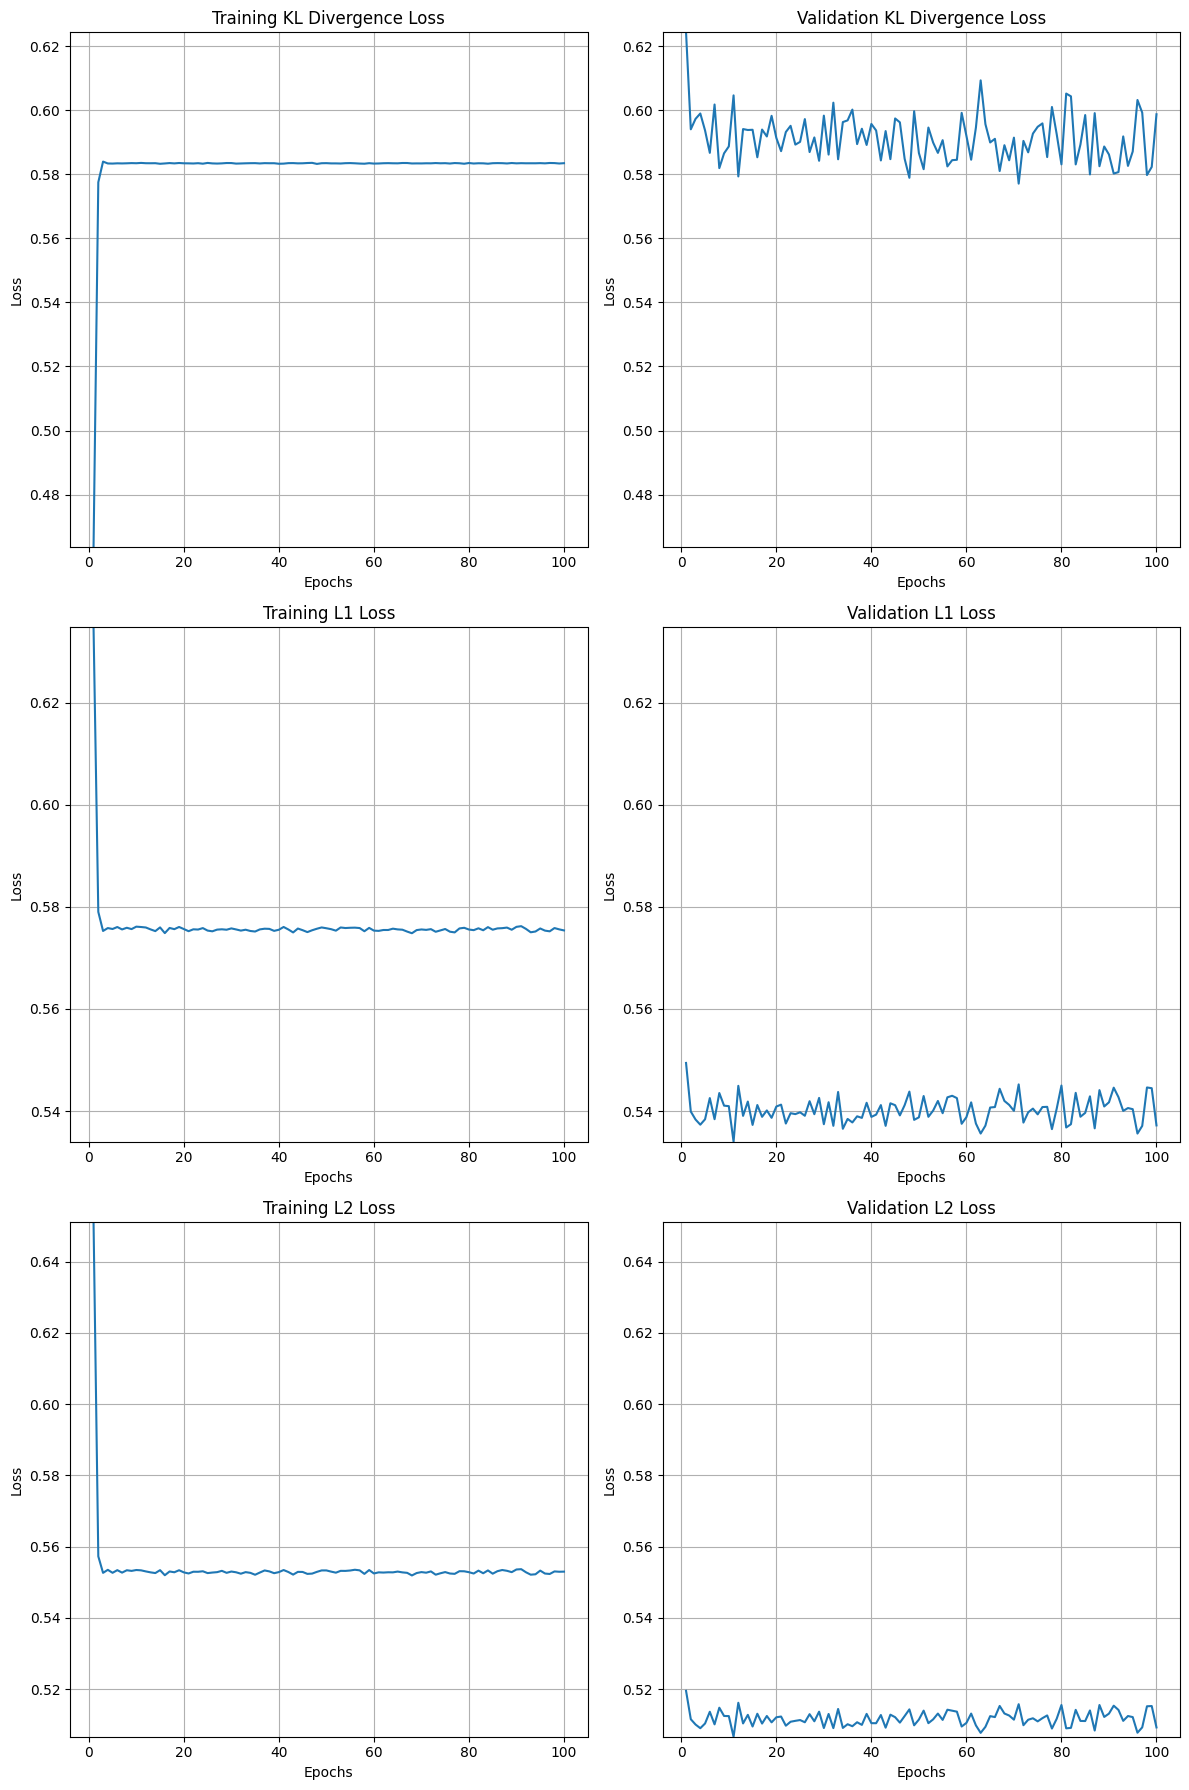

In [13]:
# * * * * * * * * * * * * * * * *
# Plot Losses
# * * * * * * * * * * * * * * * *
PlotLosses(losses, EPOCHS, model_dir)
SaveLossesToCSV(losses, os.path.join(model_dir, "losses.csv"))

In [14]:
# * * * * * * * * * * * * * * * *
# Best Validation Loss
# * * * * * * * * * * * * * * * *
PrintAndLog(log_filepath, "Best Validation Loss in Kelvins:\n")
PrintAndLog(
	log_filepath,
	f"\t{min(losses['val_l1_losses'])*x_data_std:.4f} K\n")

Best Validation Loss in Kelvins:
50.4360 K


In [15]:
# * * * * * * * * * * * * * * * *
# Sample
# * * * * * * * * * * * * * * * *
z_sample = SampleLatentSpace(
	vae,
	test_loader,
	scaler,
	DEVICE,
	model_dir
)

[Sampling]: 100%|██████████| 4/4 [00:09<00:00,  2.37s/it]


z0: -0.0220
z1: -0.0015
z2: -0.0298
z3: 0.0021


Traversing Latent Dimension z3: 100%|██████████| 11/11 [00:00<00:00, 655.47it/s]


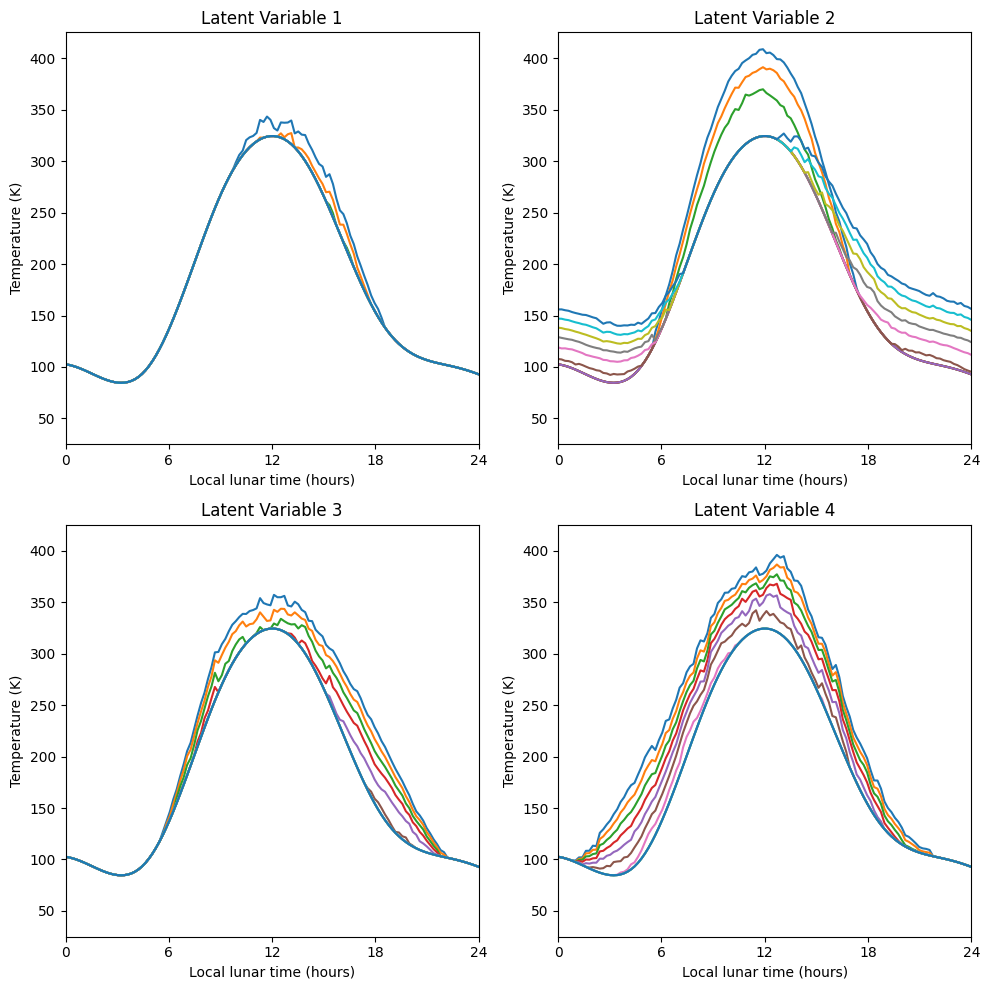

In [16]:
# * * * * * * * * * * * * * * * *
# Analyze Latent Space
# * * * * * * * * * * * * * * * *
mean_latent_vals = GetMeanLatentValues(z_sample, LATENT_DIM)
for i in range(LATENT_DIM):
	print(f"z{i}: {mean_latent_vals[i]:.4f}")

VisualizeLatentSpace(
	vae, LATENT_DIM, z_sample,
	scaler, DEVICE, model_dir)